This notebook also serves as an introduction to Tensorflow and Keras for text processing and classification. Inspired from official Tensorflow tutorials.

##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

**Note**: In this notebook we will see an end-to-end pipeline using a different way we can do text preprocessing and model training, using Tensorflow and Keras. 
Alternatively, other preprocessing libraries (such as NLTK) can be used for preprocessing and mixed with Tensorflow for model training - this is also a good option when we want to train neural networks for text classification.
There are also different ways to do data loading/preprocessing in Tensorflow, some of which more concise - we will see these in future labs.

# Basic text classification

This tutorial demonstrates text classification starting from plain text files stored on disk. You'll train a binary classifier to perform sentiment analysis on an IMDB dataset.

In [3]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


In [4]:
print(tf.__version__)

2.9.2


## Sentiment analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review. This is an example of *binary*—or two-class—classification.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews.


### Download and explore the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.

In [5]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84125825/84125825 [==============================] - 3s 0us/step


In [6]:
os.listdir(dataset_dir)

['imdb.vocab', 'train', 'imdbEr.txt', 'test', 'README']

In [7]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_neg.txt',
 'urls_unsup.txt',
 'unsupBow.feat',
 'labeledBow.feat',
 'neg',
 'pos',
 'unsup',
 'urls_pos.txt']

The `aclImdb/train/pos` and `aclImdb/train/neg` directories contain many text files, each of which is a single movie review. Let's take a look at one of them.

In [8]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


### Load the dataset

Next, you will load the data off disk and prepare it into a format suitable for training. To do so, you will use the helpful [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) utility, which expects a directory structure as follows.

```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

To prepare a dataset for binary classification, you will need two folders on disk, corresponding to `class_a` and `class_b`. These will be the positive and negative movie reviews, which can be found in  `aclImdb/train/pos` and `aclImdb/train/neg`. As the IMDB dataset contains additional folders, you will remove them before using this utility.

In [9]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`. [tf.data](https://www.tensorflow.org/guide/data) is a powerful collection of tools for working with data. 

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

In [10]:
batch_size = 32
seed = 49

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


As you can see above, there are 25,000 examples in the training folder, of which you will use 80% (or 20,000) for training. As you will see in a moment, you can train a model by passing a dataset directly to `model.fit`. If you're new to `tf.data`, you can also iterate over the dataset and print out a few examples as follows.

In [11]:
for text_batch, label_batch in raw_train_ds.take(1): # Creates a Dataset with at most 1 elements from this dataset.
  for i in range(3):
    print(i, "Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

0 Review b"This is the movie for those who believe cinema is the seventh art, not an entertainment business. Lars von Trier creates a noir atmosphere of post-war Germany utterly captivating. You get absorbed into the dream and you're let go only at the end credits. The plot necessarily comes second, but it still is a thrilling story with tough issues being raised. Just wonderful."
Label 1
1 Review b"no movie with dennis hopper, gary busey, erika eleniak, tom berenger, dean stockwell, marilu henner deserves a rating under 5 on here. This is a poor mans version of movies like 16 blocks or the timeless Midnight run except the prisoner being transported here is the very easy on the eye Ms.Eleniak. Tom Berenger plays another gruff, maverick military type well and William Mcnamara plays his rookie-about to be discharged foil well. The plot on the face of it is absurd because I lost count of the times Eleniak should have and could have escaped but this is an entertaining feel-good movie and t

Notice the reviews contain raw text (with punctuation and occasional HTML tags like `<br/>`). You will show how to handle these in the following section. 

The labels are 0 or 1. To see which of these correspond to positive and negative movie reviews, you can check the `class_names` property on the dataset.


In [12]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [13]:
# Number of positive examples in the batch
nr_pos = 0
for text_batch, label_batch in raw_train_ds.take(1):
  print(label_batch.numpy())
  nr_pos = label_batch.numpy().sum()

print(nr_pos, "out of", batch_size, "are positive")

[1 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 0 0 0 1 1 0 1 1 1 1 0 0 0 1 1 0]
16 out of 32 are positive


Next, you will create a validation and test dataset. You will use the remaining 5,000 reviews from the training set for validation.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [14]:
# Validation set
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [15]:
tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    # validation_split=0.2, 
    # subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [16]:
# Test set
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


### Prepare the dataset for training

Next, you will normalize, tokenize, and vectorize the data using the helpful `tf.keras.layers.TextVectorization` layer. 

As you saw above, the reviews contain various HTML tags like `<br />`. These tags will not be removed by the default standardizer in the `TextVectorization` layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

Note: to prevent [train/test skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew) (also know as train/serving skew), it is important to preprocess the data identically at train and test time. To facilitate this, the `TextVectorization` layer can be included directly inside your model, as shown later in this tutorial.

In [17]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Next, you will create a `TextVectorization` layer. You will use this layer to standardize, tokenize, and vectorize our data. You set the `output_mode` to `int` to create unique integer indices for each token.

Note that you're using the default split function, and the custom standardization function you defined above. You'll also define some constants for the model, like an explicit maximum `sequence_length`, which will cause the layer to pad or truncate sequences to exactly `sequence_length` values.

In [18]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = max_features,
    output_mode = 'int',
    output_sequence_length = sequence_length)

Next, you will call `adapt` to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

Note: it's important to only use your training data when calling adapt (using the test set would leak information).

In [19]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Let's create a function to see the result of using this layer to preprocess some data.

In [20]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [21]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b"the only thing that frequently pops into my head while i'm writing this review is,i'll never get that hour and a half back!!! to indicate that i'm not just blowing air, i'll compare the movie to the other movies of the cube trilogy(cube and hypercube)!cube wasn't great but it was original and that made up for some technical flaws!hypercube as a sequel lost the advantage of originality but it came out looking pretty sharp and i even liked it beter than cube(the story was better)! but cube zero in comparison to it's predecessors really isn't worth sh*t!a complete lack of good fx, a very f*ck*d up script and just plain old bad acting don't combine well! example:all of the time during the movie i was thinking it would be incredibly stupid if ... should happen and then it would happen, so it's not very original neither! my advice: don't lose that hour and a half i lost!!!!!!!! oh and i hope this movie crashes and burns!!!!!!!", shape=(), dtype=string)
Label neg
Vectorized

As you can see above, each token has been replaced by an integer. You can lookup the token (string) that each integer corresponds to by calling `.get_vocabulary()` on the layer.

In [22]:
print("2 ---> ", vectorize_layer.get_vocabulary()[2])
print(" 313 ---> ", vectorize_layer.get_vocabulary()[313])
print(" 1 --->", vectorize_layer.get_vocabulary()[1])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

2 --->  the
 313 --->  excellent
 1 ---> [UNK]
Vocabulary size: 10000


You are nearly ready to train your model. As a final preprocessing step, you will apply the TextVectorization layer you created earlier to the train, validation, and test dataset.

In [23]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Create the model

It's time to create your neural network:

In [24]:
embedding_dim = 16

In [25]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

# [0 0 0 1 0 0 0 0 0 0 0 0 0 ... ] BoW
# [0.23 0.45 0.67 ... ] [0.25 0.35 0.37 ... ] [ ... ]   250
#model.add(layer...)

# ---16 ----
# [       ]   10000
# [       ]
# [       ]
# [       ]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

The layers are stacked sequentially to build the classifier:

1. The first layer is an `Embedding` layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.  

**Note**: these are embeddings trained from scratch on our dataset and task. A good idea might be to initialize the embedding weights with pre-trained embeddings such as `word2vec`. You can try this as an exercise (use `gensim` to load pre-trained embedding vectors for the words in our vocabulary). 
2. Next, a `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible. It is essentially averaging all word embeddings from the input into one unique representation for the given input. 

TODO: retrieve the weights of the Embedding layer

**Note**: What information are we losing by doing this? Which kinds of models could instead preserve this information? (see next time)
3. This fixed-length output vector is piped through a fully-connected (`Dense`) layer with 16 hidden units. 
4. The last layer is densely connected with a single output node.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), you'll use `losses.BinaryCrossentropy` loss function.

Now, configure the model to use an optimizer and a loss function:

In [26]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### Train the model

You will train the model by passing the `dataset` object to the fit method.

In [27]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 8s 12ms/step - loss: 0.6643 - binary_accuracy: 0.6977 - val_loss: 0.6142 - val_binary_accuracy: 0.7662
Epoch 2/10
625/625 [==============================] - 8s 12ms/step - loss: 0.5502 - binary_accuracy: 0.7985 - val_loss: 0.4964 - val_binary_accuracy: 0.8246
Epoch 3/10
625/625 [==============================] - 8s 13ms/step - loss: 0.4464 - binary_accuracy: 0.8432 - val_loss: 0.4162 - val_binary_accuracy: 0.8506
Epoch 4/10
625/625 [==============================] - 8s 12ms/step - loss: 0.3807 - binary_accuracy: 0.8657 - val_loss: 0.3687 - val_binary_accuracy: 0.8620
Epoch 5/10
625/625 [==============================] - 9s 14ms/step - loss: 0.3372 - binary_accuracy: 0.8781 - val_loss: 0.3394 - val_binary_accuracy: 0.8680
Epoch 6/10
625/625 [==============================] - 8s 13ms/step - loss: 0.3064 - binary_accuracy: 0.8893 - val_loss: 0.3206 - val_binary_accuracy: 0.8718
Epoch 7/10
625/625 [==============================] - 7s 1

In [28]:
embeddings = model.layers[0].get_weights()[0]
embeddings

array([[-0.00480261,  0.00283458, -0.01549053, ...,  0.00177848,
         0.01171873,  0.00990858],
       [ 0.05393581,  0.09918576,  0.02656469, ...,  0.07544966,
        -0.12090492, -0.10033258],
       [-0.06577573, -0.00801334, -0.02614336, ..., -0.00796653,
         0.0635413 ,  0.02094617],
       ...,
       [ 0.00513907, -0.01173862,  0.10890251, ..., -0.08195981,
         0.01184349, -0.07935681],
       [ 0.01813687,  0.04077717, -0.01771778, ...,  0.03768305,
        -0.02604038, -0.05413911],
       [ 0.00449405, -0.02331703,  0.01643287, ..., -0.03085005,
        -0.04973607, -0.04335556]], dtype=float32)

### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [29]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 7s 9ms/step - loss: 0.3143 - binary_accuracy: 0.8712
Loss:  0.3142881393432617
Accuracy:  0.8711599707603455


This fairly naive approach achieves an accuracy of about 87%.

### Create a plot of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [30]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

There are four entries: one for each monitored metric during training and validation. You can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

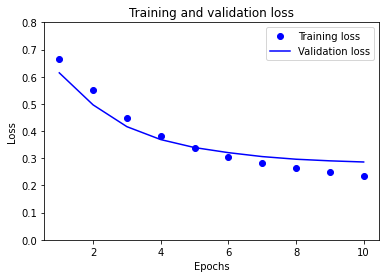

In [31]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.ylim([0, 0.8])
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

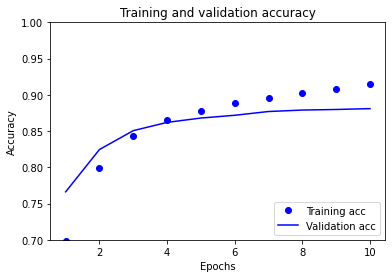

In [32]:
plt.ylim([0.7, 1])
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak before the training accuracy. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations *specific* to the training data that do not *generalize* to test data.

For this particular case, you could prevent overfitting by simply stopping the training when the validation accuracy is no longer increasing. One way to do so is to use the `tf.keras.callbacks.EarlyStopping` callback.

## Export the model

In the code above, you applied the `TextVectorization` layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the `TextVectorization` layer inside your model. To do so, you can create a new model using the weights you just trained.

In [33]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 8s 10ms/step - loss: 0.3143 - accuracy: 0.8712
0.8711599707603455


### Inference on new data

To get predictions for new examples, you can simply call `model.predict()`.

In [34]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

1/1 [==============================] - 0s 168ms/step


array([[0.64225525],
       [0.46543935],
       [0.38724247]], dtype=float32)

Including the text preprocessing logic inside your model enables you to export a model for production that simplifies deployment, and reduces the potential for [train/test skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew).

There is a performance difference to keep in mind when choosing where to apply your TextVectorization layer. Using it outside of your model enables you to do asynchronous CPU processing and buffering of your data when training on GPU. So, if you're training your model on the GPU, you probably want to go with this option to get the best performance while developing your model, then switch to including the TextVectorization layer inside your model when you're ready to prepare for deployment.

Visit this [tutorial](https://www.tensorflow.org/tutorials/keras/save_and_load) to learn more about saving models.

## Exercise: multi-class classification on Stack Overflow questions

This tutorial showed how to train a binary classifier from scratch on the IMDB dataset. As an exercise, you can modify this notebook to train a multi-class classifier to predict the tag of a programming question on [Stack Overflow](http://stackoverflow.com/).

A [dataset](http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) has been prepared for you to use containing the body of several thousand programming questions (for example, "How can sort a dictionary by value in Python?") posted to Stack Overflow. Each of these is labeled with exactly one tag (either Python, CSharp, JavaScript, or Java). Your task is to take a question as input, and predict the appropriate tag, in this case, Python. 

The dataset you will work with contains several thousand questions extracted from the much larger public Stack Overflow dataset on [BigQuery](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow), which contains more than 17 million posts.

After downloading the dataset, you will find it has a similar directory structure to the IMDB dataset you worked with previously:

```
train/
...python/
......0.txt
......1.txt
...javascript/
......0.txt
......1.txt
...csharp/
......0.txt
......1.txt
...java/
......0.txt
......1.txt
```

Note: to increase the difficulty of the classification problem, occurrences of the words Python, CSharp, JavaScript, or Java in the programming questions have been replaced with the word *blank* (as many questions contain the language they're about).

To complete this exercise, you should modify this notebook to work with the Stack Overflow dataset by making the following modifications:

1. At the top of your notebook, update the code that downloads the IMDB dataset with code to download the [Stack Overflow dataset](http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) that has been prepreared. As the Stack Overflow dataset has a similar directory structure, you will not need to make many modifications.

1. Modify the last layer of your model to read `Dense(4)`, as there are now four output classes.

1. When compiling the model, change the loss to `tf.keras.losses.SparseCategoricalCrossentropy`. This is the correct loss function to use for a multi-class classification problem, when the labels for each class are integers (in this case, they can be 0, *1*, *2*, or *3*). In addition, change the metrics to `metrics=['accuracy']`, since this is a multi-class classification problem (`tf.metrics.BinaryAccuracy` is only used for binary classifiers).

1. When plotting accuracy over time, change `binary_accuracy` and `val_binary_accuracy` to `accuracy` and `val_accuracy`, respectively.

1. Once these changes are complete, you will be able to train a multi-class classifier. 

In [35]:
url = "http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset_path = tf.keras.utils.get_file("stack_overflow_16k", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.dirname(dataset)

In [36]:
train_dir = os.path.join(dataset_dir, 'train')
print(os.listdir(train_dir))
print(os.listdir(os.path.join(train_dir, 'java')))

['javascript', 'csharp', 'java', 'python']
['422.txt', '1157.txt', '528.txt', '1830.txt', '1183.txt', '368.txt', '681.txt', '1037.txt', '707.txt', '788.txt', '379.txt', '1445.txt', '1329.txt', '1282.txt', '212.txt', '1571.txt', '912.txt', '58.txt', '1927.txt', '1494.txt', '564.txt', '1391.txt', '269.txt', '1051.txt', '1666.txt', '271.txt', '1300.txt', '1617.txt', '173.txt', '562.txt', '1630.txt', '860.txt', '1194.txt', '257.txt', '1582.txt', '440.txt', '73.txt', '63.txt', '1820.txt', '1111.txt', '1147.txt', '347.txt', '1346.txt', '1815.txt', '736.txt', '1567.txt', '167.txt', '628.txt', '1310.txt', '930.txt', '1827.txt', '729.txt', '399.txt', '792.txt', '1823.txt', '1560.txt', '1233.txt', '226.txt', '1513.txt', '1248.txt', '690.txt', '192.txt', '470.txt', '1789.txt', '740.txt', '716.txt', '777.txt', '1333.txt', '1490.txt', '1772.txt', '32.txt', '482.txt', '387.txt', '119.txt', '76.txt', '341.txt', '1007.txt', '1122.txt', '1325.txt', '1016.txt', '1188.txt', '797.txt', '1600.txt', '1330.t

In [37]:
sample_file = os.path.join(train_dir, "java", "212.txt")
with open(sample_file) as f:
  print(f.read())

"class a keyword or a class? when we create a class class_name, we code:..class class_name.{ .}...is the word class a keyword or it is a class?"



In [38]:
batch_size = 32
seed = 49

# Train set
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [39]:
for text_batch, label_batch in raw_train_ds.take(1): # Creates a Dataset with at most 1 elements from this dataset.
  for i in range(3):
    print(i, "Question", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

0 Question b'"program doesn\'t see matrix and complex numbers. is that importing library problem? i don\'t know how to make matrix and complex numbers visible for the program. it is problem with library or bad.there are errors like: name \'i\' is not defined or \'matrix\'is not defined. thank you in advance for help - i\'m a total beginner in blank...import cmath.import numpy.a=7.b=-2*i.c=2*i.d=81..a=matrix(qqbar,6,6).for i in range(0,6):.    a[i,0]=a**i.    a[i,1]=b**i.    a[i,2]=c**i.    a[i,3]=d**i.    a[i,4]=d**i*i.    a[i,5]=d**i*i*i.    a[0,6]=7.    a[1,6]=8.    a[2,6]=-7.    a[3,6]=1..print(a)..h=0.k=0..while h &lt;6 and k &lt;7:.    maxelement=0.    for z in range(0,6):.        if abs(a[h,z])&gt;maxelement:.            maxelement=abs(a[h,z]).            i_max=z.            if a[i_max,k]==0:.                k=k+1.            else:.                a.swap_rows(h,i_max).                for y in range(h+1,6):.                    f=a[i,k]/a[h,k].                    a[i,k]=0.         

In [40]:
print(f"Label 0 corresponds to {raw_train_ds.class_names[0]}")
print(f"Label 1 corresponds to {raw_train_ds.class_names[1]}")
print(f"Label 2 corresponds to {raw_train_ds.class_names[2]}")
print(f"Label 3 corresponds to {raw_train_ds.class_names[3]}")

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


In [41]:
import numpy as np

# Number of examples for each class in the batch
for text_batch, label_batch in raw_train_ds.take(1):
  count_labels = np.bincount(label_batch.numpy())
  print(count_labels)

[ 8  9  4 11]


In [42]:
# Validation set
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [43]:
# Test set
test_dir = os.path.join(dataset_dir, 'test')

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir, 
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


In [44]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [45]:
train_data = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_data)

In [46]:
train_data = raw_train_ds.map(vectorize_text)
val_data = raw_val_ds.map(vectorize_text)
test_data = raw_test_ds.map(vectorize_text)

In [61]:
embedding_dim = 32

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4)])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 32)          320032    
                                                                 
 dropout_6 (Dropout)         (None, None, 32)          0         
                                                                 
 global_average_pooling1d_3   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 4)                 132       
                                                                 
Total params: 320,164
Trainable params: 320,164
Non-trainable params: 0
________________________________________________

In [62]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=["accuracy"])

In [63]:
epochs = 20
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs)

Epoch 1/20
200/200 [==============================] - 3s 15ms/step - loss: 1.3735 - accuracy: 0.3564 - val_loss: 1.3569 - val_accuracy: 0.4588
Epoch 2/20
200/200 [==============================] - 2s 12ms/step - loss: 1.3217 - accuracy: 0.4938 - val_loss: 1.2933 - val_accuracy: 0.5069
Epoch 3/20
200/200 [==============================] - 3s 13ms/step - loss: 1.2306 - accuracy: 0.5611 - val_loss: 1.2018 - val_accuracy: 0.5819
Epoch 4/20
200/200 [==============================] - 3s 16ms/step - loss: 1.1247 - accuracy: 0.6239 - val_loss: 1.1088 - val_accuracy: 0.6544
Epoch 5/20
200/200 [==============================] - 2s 12ms/step - loss: 1.0223 - accuracy: 0.6878 - val_loss: 1.0239 - val_accuracy: 0.6963
Epoch 6/20
200/200 [==============================] - 2s 12ms/step - loss: 0.9330 - accuracy: 0.7294 - val_loss: 0.9501 - val_accuracy: 0.7212
Epoch 7/20
200/200 [==============================] - 2s 12ms/step - loss: 0.8520 - accuracy: 0.7591 - val_loss: 0.8880 - val_accuracy: 0.7287

In [64]:
loss, accuracy = model.evaluate(test_data)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 2s 9ms/step - loss: 0.5812 - accuracy: 0.7881
Loss:  0.5812103748321533
Accuracy:  0.7881249785423279


In [65]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

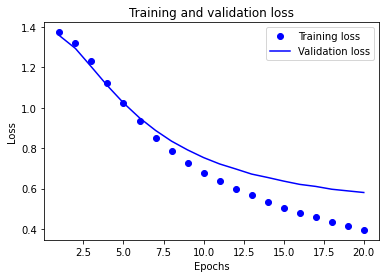

In [66]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

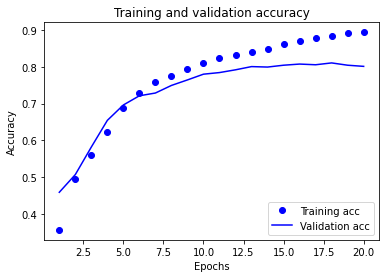

In [67]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()